In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=2

In [3]:
print FOLD

2


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                                            
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.02,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.02,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [24]:
j=FOLD
validpreds={}

In [25]:
p = Pool(1,maxtasksperchild=1)



1
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)
(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(5803, 1, 28) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 252) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40135	valid-rmse:2.36331
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.987946	valid-rmse:0.976196
[100]	train-rmse:0.576745	valid-rmse:0.584179
[150]	train-rmse:0.492129	valid-rmse:0.511204
[200]	train-rmse:0.47554	valid-rmse:0.501226
[250]	train-rmse:0.469835	valid-rmse:0.500109
[300]	train-rmse:0.465657	valid-rmse:0.50007
Stopping. Best iteration:
[272]	train-rmse:0.46799	valid-rmse:0.500013

0.21901473 0.2500132
[0.2500132]
-1 mean score 0.2500132
0.195067718625


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905238  0.023872  0.208518    7  2017-04-16
472     2.507290  2.529165 -0.021875  0.206144    1  2017-04-17
473     2.661330  2.649155  0.012175  0.227798    2  2017-04-18
474     2.754815  2.739079  0.015735  0.191142    3  2017-04-19
475     2.713762  2.704966  0.008796  0.216403    4  2017-04-20
476     2.999000  2.981348  0.017652  0.143957    5  2017-04-21
477     3.075529  3.081049 -0.005520  0.171512    6  2017-04-22

0.195067718625


pred         y     error    error2  day        date
dayidx                                                         
471     2.905238  2.929110  0.023872  0.208518    7  2017-04-16
472     2.529165  2.507290 -0.021875  0.206144    1  2017-04-17
473     2.649155  2.661330  0.012175  0.227798    2  2017-04-18
474     2.739079  2.754815  0.015735  0.191142    3  2017-04-19
475     2.704966  2.713762  0.008796  0.216403    4  2017-04-20
476     2.981348  2.999000  0.017652  0.143957    5  2017-04-21
477     3.081049  3.075529 -0.005520  0.171512    6  2017-04-22

(829, 252)


In [26]:
results=p.map(ff, range(1,40),chunksize=1)



2
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(6632, 1, 28) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 252) (6632,) (6632,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.42401	valid-rmse:2.38693
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992822	valid-rmse:0.980512
[100]	train-rmse:0.57327	valid-rmse:0.579974
[150]	train-rmse:0.486047	valid-rmse:0.505069
[200]	train-rmse:0.468697	valid-rmse:0.494953
[250]	train-rmse:0.462986	valid-rmse:0.493847
[300]	train-rmse:0.458984	valid-rmse:0.493759
Stopping. Best iteration:
[277]	train-rmse:0.460773	valid-rmse:0.493731

0.21231188 0.24377027
[0.24377027]
-1 mean score 0.24377027
0.371

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.874580  0.054530  0.261888    7  2017-04-16
472     2.507290  2.250482  0.256809  0.631915    1  2017-04-17
473     2.661330  2.453515  0.207814  0.498950    2  2017-04-18
474     2.754815  2.630494  0.124321  0.353853    3  2017-04-19
475     2.713762  2.615997  0.097765  0.336409    4  2017-04-20
476     2.999000  2.912584  0.086416  0.251029    5  2017-04-21
477     3.075529  3.035569  0.039960  0.266636    6  2017-04-22

0.371525704861


pred         y     error    error2  day        date
dayidx                                                         
471     2.874580  2.929110  0.054530  0.261888    7  2017-04-16
472     2.250482  2.507290  0.256809  0.631915    1  2017-04-17
473     2.453515  2.661330  0.207814  0.498950    2  2017-04-18
474     2.630494  2.754815  0.124321  0.353853    3  2017-04-19
475     2.615997  2.713762  0.097765  0.336409    4  2017-04-20
476     2.912584  2.999000  0.086416  0.251029    5  2017-04-21
477     3.035569  3.075529  0.039960  0.266636    6  2017-04-22

(829, 252)


3
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(7461, 1, 28) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 252) (7461,) (7461,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.41681	valid-rmse:2.37704
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99219	valid-rmse:0.980316
[100]	train-rmse:0.575863	valid-rmse:0.583973
[150]	train-rmse:0.489344	valid-rmse:0.509749
[200]	train-rmse:0.472514	valid-rmse:0.499613
[250]	train-rmse:0.46673	valid-rmse:0.498517
[300]	train-rmse:0.462893	valid-rmse:0.498474
Stopping. Best iteration:
[279]	train-rmse:0.464334	valid-rmse:0.498446

0.2156063 0.24844854
[0.24844854]
-1 mean score 0.24844854
0.39031

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.852829  0.076281  0.280139    7  2017-04-16
472     2.507290  2.484611  0.022679  0.269856    1  2017-04-17
473     2.661330  2.352087  0.309243  0.670485    2  2017-04-18
474     2.754815  2.523366  0.231449  0.507811    3  2017-04-19
475     2.713762  2.603240  0.110522  0.351317    4  2017-04-20
476     2.999000  2.878475  0.120525  0.303736    5  2017-04-21
477     3.075529  2.978194  0.097335  0.348867    6  2017-04-22

0.390315949917


pred         y     error    error2  day        date
dayidx                                                         
471     2.852829  2.929110  0.076281  0.280139    7  2017-04-16
472     2.484611  2.507290  0.022679  0.269856    1  2017-04-17
473     2.352087  2.661330  0.309243  0.670485    2  2017-04-18
474     2.523366  2.754815  0.231449  0.507811    3  2017-04-19
475     2.603240  2.713762  0.110522  0.351317    4  2017-04-20
476     2.878475  2.999000  0.120525  0.303736    5  2017-04-21
477     2.978194  3.075529  0.097335  0.348867    6  2017-04-22

(829, 252)


4
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(8290, 1, 28) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 252) (8290,) (8290,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40875	valid-rmse:2.36948
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.98996	valid-rmse:0.978532
[100]	train-rmse:0.576038	valid-rmse:0.585188
[150]	train-rmse:0.490157	valid-rmse:0.512176
[200]	train-rmse:0.473168	valid-rmse:0.50222
[250]	train-rmse:0.467314	valid-rmse:0.50114
[300]	train-rmse:0.463353	valid-rmse:0.501202
Stopping. Best iteration:
[256]	train-rmse:0.466781	valid-rmse:0.501097

0.21788436 0.2510983
[0.2510983]
-1 mean score 0.2510983
0.42250007

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.784626  0.144484  0.424700    7  2017-04-16
472     2.507290  2.509244 -0.001953  0.224695    1  2017-04-17
473     2.661330  2.587180  0.074150  0.290689    2  2017-04-18
474     2.754815  2.410645  0.344170  0.711711    3  2017-04-19
475     2.713762  2.504110  0.209652  0.493649    4  2017-04-20
476     2.999000  2.856041  0.142959  0.325073    5  2017-04-21
477     3.075529  2.912708  0.162821  0.486983    6  2017-04-22

0.42250007391


pred         y     error    error2  day        date
dayidx                                                         
471     2.784626  2.929110  0.144484  0.424700    7  2017-04-16
472     2.509244  2.507290 -0.001953  0.224695    1  2017-04-17
473     2.587180  2.661330  0.074150  0.290689    2  2017-04-18
474     2.410645  2.754815  0.344170  0.711711    3  2017-04-19
475     2.504110  2.713762  0.209652  0.493649    4  2017-04-20
476     2.856041  2.999000  0.142959  0.325073    5  2017-04-21
477     2.912708  3.075529  0.162821  0.486983    6  2017-04-22

(829, 252)


5
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(9119, 1, 28) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 252) (9119,) (9119,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40424	valid-rmse:2.36426
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.989102	valid-rmse:0.976835
[100]	train-rmse:0.576925	valid-rmse:0.585255
[150]	train-rmse:0.491505	valid-rmse:0.512878
[200]	train-rmse:0.474694	valid-rmse:0.503151
[250]	train-rmse:0.468615	valid-rmse:0.502176
[300]	train-rmse:0.464374	valid-rmse:0.50225
Stopping. Best iteration:
[259]	train-rmse:0.467816	valid-rmse:0.502174

0.21885169 0.2521789
[0.2521789]
-1 mean score 0.2521789
0.465590

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.684751  0.244359  0.618768    7  2017-04-16
472     2.507290  2.459071  0.048219  0.302229    1  2017-04-17
473     2.661330  2.614623  0.046707  0.249044    2  2017-04-18
474     2.754815  2.658438  0.096376  0.283954    3  2017-04-19
475     2.713762  2.388335  0.325426  0.710303    4  2017-04-20
476     2.999000  2.716752  0.282248  0.578573    5  2017-04-21
477     3.075529  2.899747  0.175782  0.516263    6  2017-04-22

0.465590387583


pred         y     error    error2  day        date
dayidx                                                         
471     2.684751  2.929110  0.244359  0.618768    7  2017-04-16
472     2.459071  2.507290  0.048219  0.302229    1  2017-04-17
473     2.614623  2.661330  0.046707  0.249044    2  2017-04-18
474     2.658438  2.754815  0.096376  0.283954    3  2017-04-19
475     2.388335  2.713762  0.325426  0.710303    4  2017-04-20
476     2.716752  2.999000  0.282248  0.578573    5  2017-04-21
477     2.899747  3.075529  0.175782  0.516263    6  2017-04-22

(829, 252)


6
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 15.133374
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(9948, 1, 28) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 252) (9948,) (9948,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39786	valid-rmse:2.35762
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.987931	valid-rmse:0.976149
[100]	train-rmse:0.578283	valid-rmse:0.586805
[150]	train-rmse:0.493691	valid-rmse:0.514592
[200]	train-rmse:0.476881	valid-rmse:0.504775
[250]	train-rmse:0.471331	valid-rmse:0.50371
[300]	train-rmse:0.467395	valid-rmse:0.503684
Stopping. Best iteration:
[264]	train-rmse:0.470014	valid-rmse:0.503638

0.22091326 0.25365135
[0.25365135]
-1 mean score 0.25365135
0.495

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.723048  0.206062  0.551308    7  2017-04-16
472     2.507290  2.395186  0.112105  0.402566    1  2017-04-17
473     2.661330  2.569931  0.091398  0.332416    2  2017-04-18
474     2.754815  2.703979  0.050836  0.219459    3  2017-04-19
475     2.713762  2.641077  0.072685  0.314433    4  2017-04-20
476     2.999000  2.588806  0.410194  0.906376    5  2017-04-21
477     3.075529  2.758565  0.316964  0.742513    6  2017-04-22

0.49558159709


pred         y     error    error2  day        date
dayidx                                                         
471     2.723048  2.929110  0.206062  0.551308    7  2017-04-16
472     2.395186  2.507290  0.112105  0.402566    1  2017-04-17
473     2.569931  2.661330  0.091398  0.332416    2  2017-04-18
474     2.703979  2.754815  0.050836  0.219459    3  2017-04-19
475     2.641077  2.713762  0.072685  0.314433    4  2017-04-20
476     2.588806  2.999000  0.410194  0.906376    5  2017-04-21
477     2.758565  3.075529  0.316964  0.742513    6  2017-04-22

(829, 252)


7
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 16.310143
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(10777, 1, 28) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 252) (10777,) (10777,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.41287	valid-rmse:2.37817
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991591	valid-rmse:0.982148
[100]	train-rmse:0.577221	valid-rmse:0.586229
[150]	train-rmse:0.491689	valid-rmse:0.51225
[200]	train-rmse:0.474798	valid-rmse:0.502007
[250]	train-rmse:0.468972	valid-rmse:0.500778
[300]	train-rmse:0.464716	valid-rmse:0.50071
Stopping. Best iteration:
[292]	train-rmse:0.46533	valid-rmse:0.500653

0.21653192 0.25065306
[0.25065306]
-1 mean score 0.25065306


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.643125  0.285985  0.631894    7  2017-04-16
472     2.507290  2.474915  0.032376  0.293533    1  2017-04-17
473     2.661330  2.547925  0.113405  0.346222    2  2017-04-18
474     2.754815  2.672922  0.081893  0.274942    3  2017-04-19
475     2.713762  2.688584  0.025178  0.248036    4  2017-04-20
476     2.999000  2.922696  0.076303  0.235223    5  2017-04-21
477     3.075529  2.834303  0.241227  0.524320    6  2017-04-22

0.364881366491


pred         y     error    error2  day        date
dayidx                                                         
471     2.643125  2.929110  0.285985  0.631894    7  2017-04-16
472     2.474915  2.507290  0.032376  0.293533    1  2017-04-17
473     2.547925  2.661330  0.113405  0.346222    2  2017-04-18
474     2.672922  2.754815  0.081893  0.274942    3  2017-04-19
475     2.688584  2.713762  0.025178  0.248036    4  2017-04-20
476     2.922696  2.999000  0.076303  0.235223    5  2017-04-21
477     2.834303  3.075529  0.241227  0.524320    6  2017-04-22

(829, 252)


8
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 17.574337
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(11606, 1, 28) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 252) (11606,) (11606,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.42568	valid-rmse:2.39028
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994686	valid-rmse:0.98519
[100]	train-rmse:0.576207	valid-rmse:0.586015
[150]	train-rmse:0.489489	valid-rmse:0.511121
[200]	train-rmse:0.472585	valid-rmse:0.50083
[250]	train-rmse:0.466696	valid-rmse:0.49967
[300]	train-rmse:0.462605	valid-rmse:0.499593
[350]	train-rmse:0.459065	valid-rmse:0.499624
Stopping. Best iteration:
[333]	train-rmse:0.46021	valid-rmse:0.499564

0.21179329 0.24

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.870209  0.058901  0.279647    7  2017-04-16
472     2.507290  2.510197 -0.002906  0.253379    1  2017-04-17
473     2.661330  2.613564  0.047766  0.254977    2  2017-04-18
474     2.754815  2.691691  0.063124  0.253966    3  2017-04-19
475     2.713762  2.690531  0.023230  0.250784    4  2017-04-20
476     2.999000  2.952656  0.046344  0.169746    5  2017-04-21
477     3.075529  3.056264  0.019265  0.213160    6  2017-04-22

0.239379972219


pred         y     error    error2  day        date
dayidx                                                         
471     2.870209  2.929110  0.058901  0.279647    7  2017-04-16
472     2.510197  2.507290 -0.002906  0.253379    1  2017-04-17
473     2.613564  2.661330  0.047766  0.254977    2  2017-04-18
474     2.691691  2.754815  0.063124  0.253966    3  2017-04-19
475     2.690531  2.713762  0.023230  0.250784    4  2017-04-20
476     2.952656  2.999000  0.046344  0.169746    5  2017-04-21
477     3.056264  3.075529  0.019265  0.213160    6  2017-04-22

(829, 252)


9
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 18.806503
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(12435, 1, 28) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 252) (12435,) (12435,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.42556	valid-rmse:2.38743
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997366	valid-rmse:0.98693
[100]	train-rmse:0.580935	valid-rmse:0.59067
[150]	train-rmse:0.494609	valid-rmse:0.516821
[200]	train-rmse:0.477464	valid-rmse:0.506636
[250]	train-rmse:0.471784	valid-rmse:0.50557
[300]	train-rmse:0.467062	valid-rmse:0.505588
[350]	train-rmse:0.463264	valid-rmse:0.5056
Stopping. Best iteration:
[319]	train-rmse:0.465598	valid-rmse:0.505528

0.21678124 0.255

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.878792  0.050318  0.279325    7  2017-04-16
472     2.507290  2.246973  0.260317  0.650578    1  2017-04-17
473     2.661330  2.483649  0.177680  0.455896    2  2017-04-18
474     2.754815  2.637112  0.117703  0.341437    3  2017-04-19
475     2.713762  2.604263  0.109499  0.388758    4  2017-04-20
476     2.999000  2.905751  0.093249  0.250660    5  2017-04-21
477     3.075529  3.050782  0.024748  0.238465    6  2017-04-22

0.372159689665


pred         y     error    error2  day        date
dayidx                                                         
471     2.878792  2.929110  0.050318  0.279325    7  2017-04-16
472     2.246973  2.507290  0.260317  0.650578    1  2017-04-17
473     2.483649  2.661330  0.177680  0.455896    2  2017-04-18
474     2.637112  2.754815  0.117703  0.341437    3  2017-04-19
475     2.604263  2.713762  0.109499  0.388758    4  2017-04-20
476     2.905751  2.999000  0.093249  0.250660    5  2017-04-21
477     3.050782  3.075529  0.024748  0.238465    6  2017-04-22

(829, 252)


10
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 19.926521
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(13264, 1, 28) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 252) (13264,) (13264,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.41755	valid-rmse:2.37749
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996434	valid-rmse:0.984954
[100]	train-rmse:0.583549	valid-rmse:0.591537
[150]	train-rmse:0.498036	valid-rmse:0.518084
[200]	train-rmse:0.480975	valid-rmse:0.507899
[250]	train-rmse:0.475049	valid-rmse:0.50675
[300]	train-rmse:0.470437	valid-rmse:0.506774
Stopping. Best iteration:
[269]	train-rmse:0.473055	valid-rmse:0.506698

0.22378142 0.25674254
[0.25674254]
-1 mean score 0.2567425

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.838954  0.090156  0.324735    7  2017-04-16
472     2.507290  2.478384  0.028907  0.290079    1  2017-04-17
473     2.661330  2.298415  0.362914  0.782463    2  2017-04-18
474     2.754815  2.496942  0.257873  0.548538    3  2017-04-19
475     2.713762  2.602709  0.111052  0.355719    4  2017-04-20
476     2.999000  2.817696  0.181304  0.376079    5  2017-04-21
477     3.075529  2.971731  0.103798  0.387728    6  2017-04-22

0.437905788422


pred         y     error    error2  day        date
dayidx                                                         
471     2.838954  2.929110  0.090156  0.324735    7  2017-04-16
472     2.478384  2.507290  0.028907  0.290079    1  2017-04-17
473     2.298415  2.661330  0.362914  0.782463    2  2017-04-18
474     2.496942  2.754815  0.257873  0.548538    3  2017-04-19
475     2.602709  2.713762  0.111052  0.355719    4  2017-04-20
476     2.817696  2.999000  0.181304  0.376079    5  2017-04-21
477     2.971731  3.075529  0.103798  0.387728    6  2017-04-22

(829, 252)


11
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 21.05768
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(14093, 1, 28) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 252) (14093,) (14093,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40955	valid-rmse:2.3692
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994214	valid-rmse:0.983394
[100]	train-rmse:0.583495	valid-rmse:0.593036
[150]	train-rmse:0.498594	valid-rmse:0.52039
[200]	train-rmse:0.481731	valid-rmse:0.510165
[250]	train-rmse:0.476184	valid-rmse:0.508985
[300]	train-rmse:0.472347	valid-rmse:0.508914
Stopping. Best iteration:
[273]	train-rmse:0.474273	valid-rmse:0.508894

0.22493477 0.2589729
[0.2589729]
-1 mean score 0.2589729
0.

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.768591  0.160519  0.452844    7  2017-04-16
472     2.507290  2.506977  0.000314  0.243306    1  2017-04-17
473     2.661330  2.594783  0.066546  0.307228    2  2017-04-18
474     2.754815  2.373501  0.381314  0.774798    3  2017-04-19
475     2.713762  2.511708  0.202054  0.502428    4  2017-04-20
476     2.999000  2.848122  0.150878  0.338225    5  2017-04-21
477     3.075529  2.882375  0.193154  0.549363    6  2017-04-22

0.452598750591


pred         y     error    error2  day        date
dayidx                                                         
471     2.768591  2.929110  0.160519  0.452844    7  2017-04-16
472     2.506977  2.507290  0.000314  0.243306    1  2017-04-17
473     2.594783  2.661330  0.066546  0.307228    2  2017-04-18
474     2.373501  2.754815  0.381314  0.774798    3  2017-04-19
475     2.511708  2.713762  0.202054  0.502428    4  2017-04-20
476     2.848122  2.999000  0.150878  0.338225    5  2017-04-21
477     2.882375  3.075529  0.193154  0.549363    6  2017-04-22

(829, 252)


12
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 22.115147
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(14922, 1, 28) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 252) (14922,) (14922,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.405	valid-rmse:2.36368
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993507	valid-rmse:0.981064
[100]	train-rmse:0.584792	valid-rmse:0.592656
[150]	train-rmse:0.500294	valid-rmse:0.52083
[200]	train-rmse:0.483256	valid-rmse:0.510947
[250]	train-rmse:0.477361	valid-rmse:0.50984
[300]	train-rmse:0.473305	valid-rmse:0.509882
Stopping. Best iteration:
[260]	train-rmse:0.476472	valid-rmse:0.509824

0.22702533 0.25992027
[0.25992027]
-1 mean score 0.25992027
0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.713730  0.215380  0.554583    7  2017-04-16
472     2.507290  2.464682  0.042609  0.301323    1  2017-04-17
473     2.661330  2.619694  0.041636  0.283033    2  2017-04-18
474     2.754815  2.660130  0.094685  0.284990    3  2017-04-19
475     2.713762  2.387303  0.326459  0.715725    4  2017-04-20
476     2.999000  2.729143  0.269857  0.513235    5  2017-04-21
477     3.075529  2.915480  0.160049  0.455236    6  2017-04-22

0.444017738104


pred         y     error    error2  day        date
dayidx                                                         
471     2.713730  2.929110  0.215380  0.554583    7  2017-04-16
472     2.464682  2.507290  0.042609  0.301323    1  2017-04-17
473     2.619694  2.661330  0.041636  0.283033    2  2017-04-18
474     2.660130  2.754815  0.094685  0.284990    3  2017-04-19
475     2.387303  2.713762  0.326459  0.715725    4  2017-04-20
476     2.729143  2.999000  0.269857  0.513235    5  2017-04-21
477     2.915480  3.075529  0.160049  0.455236    6  2017-04-22

(829, 252)


13
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 23.15517
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(15751, 1, 28) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 252) (15751,) (15751,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39798	valid-rmse:2.35674
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991389	valid-rmse:0.980272
[100]	train-rmse:0.584587	valid-rmse:0.594649
[150]	train-rmse:0.50059	valid-rmse:0.523299
[200]	train-rmse:0.483862	valid-rmse:0.513431
[250]	train-rmse:0.478349	valid-rmse:0.512287
[300]	train-rmse:0.47395	valid-rmse:0.512218
Stopping. Best iteration:
[291]	train-rmse:0.474702	valid-rmse:0.512147

0.22534162 0.262295
[0.262295]
-1 mean score 0.262295
0.456

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.713577  0.215533  0.530602    7  2017-04-16
472     2.507290  2.440507  0.066783  0.315185    1  2017-04-17
473     2.661330  2.585074  0.076256  0.332012    2  2017-04-18
474     2.754815  2.700988  0.053827  0.248187    3  2017-04-19
475     2.713762  2.664361  0.049401  0.285841    4  2017-04-20
476     2.999000  2.597487  0.401513  0.806138    5  2017-04-21
477     3.075529  2.782991  0.292538  0.675032    6  2017-04-22

0.456142276525


pred         y     error    error2  day        date
dayidx                                                         
471     2.713577  2.929110  0.215533  0.530602    7  2017-04-16
472     2.440507  2.507290  0.066783  0.315185    1  2017-04-17
473     2.585074  2.661330  0.076256  0.332012    2  2017-04-18
474     2.700988  2.754815  0.053827  0.248187    3  2017-04-19
475     2.664361  2.713762  0.049401  0.285841    4  2017-04-20
476     2.597487  2.999000  0.401513  0.806138    5  2017-04-21
477     2.782991  3.075529  0.292538  0.675032    6  2017-04-22

(829, 252)


14
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 24.22639
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(16580, 1, 28) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 252) (16580,) (16580,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4131	valid-rmse:2.37653
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994665	valid-rmse:0.984839
[100]	train-rmse:0.58261	valid-rmse:0.592529
[150]	train-rmse:0.497285	valid-rmse:0.519676
[200]	train-rmse:0.480196	valid-rmse:0.509701
[250]	train-rmse:0.473964	valid-rmse:0.50865
[300]	train-rmse:0.469892	valid-rmse:0.508657
Stopping. Best iteration:
[286]	train-rmse:0.471066	valid-rmse:0.508594

0.22190335 0.2586682
[0.2586682]
-1 mean score 0.2586682
0.3

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.628487  0.300623  0.696506    7  2017-04-16
472     2.507290  2.449012  0.058279  0.321070    1  2017-04-17
473     2.661330  2.565934  0.095396  0.339822    2  2017-04-18
474     2.754815  2.666118  0.088697  0.290227    3  2017-04-19
475     2.713762  2.695981  0.017781  0.251921    4  2017-04-20
476     2.999000  2.928648  0.070352  0.224610    5  2017-04-21
477     3.075529  2.802514  0.273015  0.568197    6  2017-04-22

0.384622037411


pred         y     error    error2  day        date
dayidx                                                         
471     2.628487  2.929110  0.300623  0.696506    7  2017-04-16
472     2.449012  2.507290  0.058279  0.321070    1  2017-04-17
473     2.565934  2.661330  0.095396  0.339822    2  2017-04-18
474     2.666118  2.754815  0.088697  0.290227    3  2017-04-19
475     2.695981  2.713762  0.017781  0.251921    4  2017-04-20
476     2.928648  2.999000  0.070352  0.224610    5  2017-04-21
477     2.802514  3.075529  0.273015  0.568197    6  2017-04-22

(829, 252)


15
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 25.357664
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(17409, 1, 28) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 252) (17409,) (17409,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.42558	valid-rmse:2.38939
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997505	valid-rmse:0.989265
[100]	train-rmse:0.581607	valid-rmse:0.593336
[150]	train-rmse:0.495536	valid-rmse:0.519125
[200]	train-rmse:0.478261	valid-rmse:0.508714
[250]	train-rmse:0.472249	valid-rmse:0.507388
[300]	train-rmse:0.468026	valid-rmse:0.507295
Stopping. Best iteration:
[288]	train-rmse:0.468918	valid-rmse:0.507279

0.21988432 0.2573323
[0.2573323]
-1 mean score 0.2573323


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.840643  0.088467  0.298473    7  2017-04-16
472     2.507290  2.489154  0.018136  0.254496    1  2017-04-17
473     2.661330  2.600778  0.060552  0.308563    2  2017-04-18
474     2.754815  2.696086  0.058729  0.248056    3  2017-04-19
475     2.713762  2.691572  0.022189  0.244392    4  2017-04-20
476     2.999000  2.955581  0.043418  0.172070    5  2017-04-21
477     3.075529  3.051671  0.023858  0.204287    6  2017-04-22

0.24719107151


pred         y     error    error2  day        date
dayidx                                                         
471     2.840643  2.929110  0.088467  0.298473    7  2017-04-16
472     2.489154  2.507290  0.018136  0.254496    1  2017-04-17
473     2.600778  2.661330  0.060552  0.308563    2  2017-04-18
474     2.696086  2.754815  0.058729  0.248056    3  2017-04-19
475     2.691572  2.713762  0.022189  0.244392    4  2017-04-20
476     2.955581  2.999000  0.043418  0.172070    5  2017-04-21
477     3.051671  3.075529  0.023858  0.204287    6  2017-04-22

(829, 252)


16
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 26.465925
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(18238, 1, 28) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 252) (18238,) (18238,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.42502	valid-rmse:2.38866
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00042	valid-rmse:0.991575
[100]	train-rmse:0.587037	valid-rmse:0.597014
[150]	train-rmse:0.501463	valid-rmse:0.522972
[200]	train-rmse:0.484463	valid-rmse:0.51247
[250]	train-rmse:0.477847	valid-rmse:0.511227
[300]	train-rmse:0.473798	valid-rmse:0.511253
Stopping. Best iteration:
[277]	train-rmse:0.475443	valid-rmse:0.511153

0.22604582 0.2612772
[0.2612772]
-1 mean score 0.2612772
0.

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.843746  0.085364  0.306926    7  2017-04-16
472     2.507290  2.278222  0.229069  0.562837    1  2017-04-17
473     2.661330  2.489766  0.171564  0.439111    2  2017-04-18
474     2.754815  2.614711  0.140104  0.350007    3  2017-04-19
475     2.713762  2.633895  0.079867  0.329888    4  2017-04-20
476     2.999000  2.904161  0.094838  0.239500    5  2017-04-21
477     3.075529  3.025551  0.049979  0.252237    6  2017-04-22

0.354357868433


pred         y     error    error2  day        date
dayidx                                                         
471     2.843746  2.929110  0.085364  0.306926    7  2017-04-16
472     2.278222  2.507290  0.229069  0.562837    1  2017-04-17
473     2.489766  2.661330  0.171564  0.439111    2  2017-04-18
474     2.614711  2.754815  0.140104  0.350007    3  2017-04-19
475     2.633895  2.713762  0.079867  0.329888    4  2017-04-20
476     2.904161  2.999000  0.094838  0.239500    5  2017-04-21
477     3.025551  3.075529  0.049979  0.252237    6  2017-04-22

(829, 252)


17
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 27.605818
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(19067, 1, 28) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 252) (19067,) (19067,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.41757	valid-rmse:2.37691
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999137	valid-rmse:0.987322
[100]	train-rmse:0.588399	valid-rmse:0.596488
[150]	train-rmse:0.50383	valid-rmse:0.523898
[200]	train-rmse:0.486718	valid-rmse:0.51385
[250]	train-rmse:0.480361	valid-rmse:0.51268
[300]	train-rmse:0.475725	valid-rmse:0.512752
Stopping. Best iteration:
[270]	train-rmse:0.478456	valid-rmse:0.512642

0.22891991 0.26280147
[0.26280147]
-1 mean score 0.26280147


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.829801  0.099309  0.349593    7  2017-04-16
472     2.507290  2.465795  0.041496  0.297061    1  2017-04-17
473     2.661330  2.322922  0.338408  0.732047    2  2017-04-18
474     2.754815  2.507753  0.247062  0.523914    3  2017-04-19
475     2.713762  2.599406  0.114356  0.377452    4  2017-04-20
476     2.999000  2.857154  0.141845  0.334268    5  2017-04-21
477     3.075529  2.949007  0.126522  0.390175    6  2017-04-22

0.429215848446


pred         y     error    error2  day        date
dayidx                                                         
471     2.829801  2.929110  0.099309  0.349593    7  2017-04-16
472     2.465795  2.507290  0.041496  0.297061    1  2017-04-17
473     2.322922  2.661330  0.338408  0.732047    2  2017-04-18
474     2.507753  2.754815  0.247062  0.523914    3  2017-04-19
475     2.599406  2.713762  0.114356  0.377452    4  2017-04-20
476     2.857154  2.999000  0.141845  0.334268    5  2017-04-21
477     2.949007  3.075529  0.126522  0.390175    6  2017-04-22

(829, 252)


18
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 28.75126
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(19896, 1, 28) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 252) (19896,) (19896,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40849	valid-rmse:2.36806
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996271	valid-rmse:0.984791
[100]	train-rmse:0.587741	valid-rmse:0.597269
[150]	train-rmse:0.503374	valid-rmse:0.525932
[200]	train-rmse:0.486233	valid-rmse:0.51622
[250]	train-rmse:0.479979	valid-rmse:0.515192
[300]	train-rmse:0.475223	valid-rmse:0.515279
Stopping. Best iteration:
[255]	train-rmse:0.479546	valid-rmse:0.515182

0.2299645 0.26541263
[0.26541263]
-1 mean score 0.26541263

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.793171  0.135939  0.419277    7  2017-04-16
472     2.507290  2.494417  0.012873  0.251551    1  2017-04-17
473     2.661330  2.578102  0.083227  0.332422    2  2017-04-18
474     2.754815  2.400775  0.354040  0.705380    3  2017-04-19
475     2.713762  2.523839  0.189923  0.472678    4  2017-04-20
476     2.999000  2.848458  0.150542  0.339243    5  2017-04-21
477     3.075529  2.909626  0.165904  0.454439    6  2017-04-22

0.424998611212


pred         y     error    error2  day        date
dayidx                                                         
471     2.793171  2.929110  0.135939  0.419277    7  2017-04-16
472     2.494417  2.507290  0.012873  0.251551    1  2017-04-17
473     2.578102  2.661330  0.083227  0.332422    2  2017-04-18
474     2.400775  2.754815  0.354040  0.705380    3  2017-04-19
475     2.523839  2.713762  0.189923  0.472678    4  2017-04-20
476     2.848458  2.999000  0.150542  0.339243    5  2017-04-21
477     2.909626  3.075529  0.165904  0.454439    6  2017-04-22

(829, 252)


19
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 29.798643
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(20725, 1, 28) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 252) (20725,) (20725,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40278	valid-rmse:2.36382
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99471	valid-rmse:0.983681
[100]	train-rmse:0.587943	valid-rmse:0.596319
[150]	train-rmse:0.504161	valid-rmse:0.524553
[200]	train-rmse:0.486956	valid-rmse:0.514592
[250]	train-rmse:0.480894	valid-rmse:0.513406
[300]	train-rmse:0.476426	valid-rmse:0.513386
Stopping. Best iteration:
[266]	train-rmse:0.479331	valid-rmse:0.513341

0.22975828 0.2635188
[0.2635188]
-1 mean score 0.2635188
0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.727477  0.201633  0.541925    7  2017-04-16
472     2.507290  2.470517  0.036773  0.280302    1  2017-04-17
473     2.661330  2.599762  0.061568  0.309461    2  2017-04-18
474     2.754815  2.635797  0.119018  0.331508    3  2017-04-19
475     2.713762  2.381780  0.331982  0.712864    4  2017-04-20
476     2.999000  2.724169  0.274831  0.530211    5  2017-04-21
477     3.075529  2.886789  0.188740  0.483108    6  2017-04-22

0.455625683069


pred         y     error    error2  day        date
dayidx                                                         
471     2.727477  2.929110  0.201633  0.541925    7  2017-04-16
472     2.470517  2.507290  0.036773  0.280302    1  2017-04-17
473     2.599762  2.661330  0.061568  0.309461    2  2017-04-18
474     2.635797  2.754815  0.119018  0.331508    3  2017-04-19
475     2.381780  2.713762  0.331982  0.712864    4  2017-04-20
476     2.724169  2.999000  0.274831  0.530211    5  2017-04-21
477     2.886789  3.075529  0.188740  0.483108    6  2017-04-22

(829, 252)


20
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 30.796307
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(21554, 1, 28) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 252) (21554,) (21554,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39635	valid-rmse:2.3562
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993508	valid-rmse:0.981603
[100]	train-rmse:0.58908	valid-rmse:0.597065
[150]	train-rmse:0.505817	valid-rmse:0.526441
[200]	train-rmse:0.488758	valid-rmse:0.516854
[250]	train-rmse:0.482501	valid-rmse:0.515757
[300]	train-rmse:0.477585	valid-rmse:0.515989
Stopping. Best iteration:
[272]	train-rmse:0.480345	valid-rmse:0.515749

0.23073116 0.26599672
[0.26599672]
-1 mean score 0.26599672

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.718521  0.210589  0.574163    7  2017-04-16
472     2.507290  2.431974  0.075316  0.337500    1  2017-04-17
473     2.661330  2.575787  0.085543  0.338023    2  2017-04-18
474     2.754815  2.664379  0.090436  0.286285    3  2017-04-19
475     2.713762  2.644539  0.069223  0.301634    4  2017-04-20
476     2.999000  2.587459  0.411540  0.827036    5  2017-04-21
477     3.075529  2.769224  0.306305  0.668340    6  2017-04-22

0.47614005208


pred         y     error    error2  day        date
dayidx                                                         
471     2.718521  2.929110  0.210589  0.574163    7  2017-04-16
472     2.431974  2.507290  0.075316  0.337500    1  2017-04-17
473     2.575787  2.661330  0.085543  0.338023    2  2017-04-18
474     2.664379  2.754815  0.090436  0.286285    3  2017-04-19
475     2.644539  2.713762  0.069223  0.301634    4  2017-04-20
476     2.587459  2.999000  0.411540  0.827036    5  2017-04-21
477     2.769224  3.075529  0.306305  0.668340    6  2017-04-22

(829, 252)


21
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 31.792852
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(22383, 1, 28) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 252) (22383,) (22383,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.41132	valid-rmse:2.37569
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996534	valid-rmse:0.987822
[100]	train-rmse:0.587038	valid-rmse:0.597254
[150]	train-rmse:0.502386	valid-rmse:0.524553
[200]	train-rmse:0.484929	valid-rmse:0.514458
[250]	train-rmse:0.478973	valid-rmse:0.513186
[300]	train-rmse:0.473899	valid-rmse:0.513329
Stopping. Best iteration:
[271]	train-rmse:0.477075	valid-rmse:0.513098

0.22760057 0.26326978
[0.26326978]
-1 mean score 0.263269

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.647154  0.281956  0.649751    7  2017-04-16
472     2.507290  2.456751  0.050539  0.305884    1  2017-04-17
473     2.661330  2.563075  0.098255  0.354256    2  2017-04-18
474     2.754815  2.656757  0.098058  0.301793    3  2017-04-19
475     2.713762  2.662623  0.051139  0.274002    4  2017-04-20
476     2.999000  2.898851  0.100148  0.262691    5  2017-04-21
477     3.075529  2.785769  0.289760  0.570348    6  2017-04-22

0.388389259577


pred         y     error    error2  day        date
dayidx                                                         
471     2.647154  2.929110  0.281956  0.649751    7  2017-04-16
472     2.456751  2.507290  0.050539  0.305884    1  2017-04-17
473     2.563075  2.661330  0.098255  0.354256    2  2017-04-18
474     2.656757  2.754815  0.098058  0.301793    3  2017-04-19
475     2.662623  2.713762  0.051139  0.274002    4  2017-04-20
476     2.898851  2.999000  0.100148  0.262691    5  2017-04-21
477     2.785769  3.075529  0.289760  0.570348    6  2017-04-22

(829, 252)


22
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 32.870983
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(23212, 1, 28) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 252) (23212,) (23212,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.42514	valid-rmse:2.38986
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999676	valid-rmse:0.989699
[100]	train-rmse:0.585517	valid-rmse:0.594086
[150]	train-rmse:0.499601	valid-rmse:0.520172
[200]	train-rmse:0.482213	valid-rmse:0.509853
[250]	train-rmse:0.476085	valid-rmse:0.508623
[300]	train-rmse:0.471013	valid-rmse:0.508651
Stopping. Best iteration:
[268]	train-rmse:0.47433	valid-rmse:0.508545

0.22498862 0.25861773
[0.25861773]
-1 mean score 0.2586177

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.824001  0.105109  0.340524    7  2017-04-16
472     2.507290  2.480873  0.026418  0.262821    1  2017-04-17
473     2.661330  2.601030  0.060300  0.304501    2  2017-04-18
474     2.754815  2.682025  0.072790  0.270265    3  2017-04-19
475     2.713762  2.679112  0.034650  0.259521    4  2017-04-20
476     2.999000  2.923650  0.075350  0.225552    5  2017-04-21
477     3.075529  3.018984  0.056545  0.231304    6  2017-04-22

0.270641118288


pred         y     error    error2  day        date
dayidx                                                         
471     2.824001  2.929110  0.105109  0.340524    7  2017-04-16
472     2.480873  2.507290  0.026418  0.262821    1  2017-04-17
473     2.601030  2.661330  0.060300  0.304501    2  2017-04-18
474     2.682025  2.754815  0.072790  0.270265    3  2017-04-19
475     2.679112  2.713762  0.034650  0.259521    4  2017-04-20
476     2.923650  2.999000  0.075350  0.225552    5  2017-04-21
477     3.018984  3.075529  0.056545  0.231304    6  2017-04-22

(829, 252)


23
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 33.974537
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(24041, 1, 28) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 252) (24041,) (24041,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.42463	valid-rmse:2.38715
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00225	valid-rmse:0.990992
[100]	train-rmse:0.590194	valid-rmse:0.598195
[150]	train-rmse:0.504574	valid-rmse:0.525283
[200]	train-rmse:0.486814	valid-rmse:0.515307
[250]	train-rmse:0.480114	valid-rmse:0.514132
[300]	train-rmse:0.475606	valid-rmse:0.514093
Stopping. Best iteration:
[271]	train-rmse:0.478202	valid-rmse:0.514061

0.22867702 0.2642588
[0.2642588]
-1 mean score 0.2642588
0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.861393  0.067717  0.300760    7  2017-04-16
472     2.507290  2.253852  0.253438  0.584799    1  2017-04-17
473     2.661330  2.501965  0.159365  0.434261    2  2017-04-18
474     2.754815  2.631183  0.123632  0.366697    3  2017-04-19
475     2.713762  2.609607  0.104155  0.381365    4  2017-04-20
476     2.999000  2.893163  0.105836  0.265746    5  2017-04-21
477     3.075529  2.994700  0.080829  0.272434    6  2017-04-22

0.372294425964


pred         y     error    error2  day        date
dayidx                                                         
471     2.861393  2.929110  0.067717  0.300760    7  2017-04-16
472     2.253852  2.507290  0.253438  0.584799    1  2017-04-17
473     2.501965  2.661330  0.159365  0.434261    2  2017-04-18
474     2.631183  2.754815  0.123632  0.366697    3  2017-04-19
475     2.609607  2.713762  0.104155  0.381365    4  2017-04-20
476     2.893163  2.999000  0.105836  0.265746    5  2017-04-21
477     2.994700  3.075529  0.080829  0.272434    6  2017-04-22

(829, 252)


24
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 35.208443
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(24870, 1, 28) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 252) (24870,) (24870,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.41627	valid-rmse:2.37503
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00033	valid-rmse:0.987803
[100]	train-rmse:0.590966	valid-rmse:0.598705
[150]	train-rmse:0.506097	valid-rmse:0.526794
[200]	train-rmse:0.488489	valid-rmse:0.51694
[250]	train-rmse:0.482007	valid-rmse:0.51578
[300]	train-rmse:0.47689	valid-rmse:0.515917
Stopping. Best iteration:
[258]	train-rmse:0.48118	valid-rmse:0.51574

0.23153469 0.26598814
[0.26598814]
-1 mean score 0.26598814
0.3

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.849135  0.079975  0.288605    7  2017-04-16
472     2.507290  2.453045  0.054246  0.311746    1  2017-04-17
473     2.661330  2.339798  0.321531  0.697272    2  2017-04-18
474     2.754815  2.542805  0.212010  0.480969    3  2017-04-19
475     2.713762  2.610872  0.102890  0.361726    4  2017-04-20
476     2.999000  2.853461  0.145539  0.307134    5  2017-04-21
477     3.075529  2.964914  0.110615  0.345072    6  2017-04-22

0.398932039738


pred         y     error    error2  day        date
dayidx                                                         
471     2.849135  2.929110  0.079975  0.288605    7  2017-04-16
472     2.453045  2.507290  0.054246  0.311746    1  2017-04-17
473     2.339798  2.661330  0.321531  0.697272    2  2017-04-18
474     2.542805  2.754815  0.212010  0.480969    3  2017-04-19
475     2.610872  2.713762  0.102890  0.361726    4  2017-04-20
476     2.853461  2.999000  0.145539  0.307134    5  2017-04-21
477     2.964914  3.075529  0.110615  0.345072    6  2017-04-22

(829, 252)


25
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 36.335064
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(25699, 1, 28) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 252) (25699,) (25699,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40777	valid-rmse:2.3677
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998153	valid-rmse:0.986718
[100]	train-rmse:0.59144	valid-rmse:0.600104
[150]	train-rmse:0.507486	valid-rmse:0.528529
[200]	train-rmse:0.489877	valid-rmse:0.518457
[250]	train-rmse:0.482956	valid-rmse:0.517199
[300]	train-rmse:0.477974	valid-rmse:0.51714
Stopping. Best iteration:
[291]	train-rmse:0.478892	valid-rmse:0.517134

0.2293371 0.26742727
[0.26742727]
-1 mean score 0.26742727
0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.783034  0.146076  0.444165    7  2017-04-16
472     2.507290  2.485440  0.021850  0.258191    1  2017-04-17
473     2.661330  2.581069  0.080260  0.354419    2  2017-04-18
474     2.754815  2.361120  0.393694  0.819240    3  2017-04-19
475     2.713762  2.514811  0.198950  0.512616    4  2017-04-20
476     2.999000  2.847636  0.151364  0.361695    5  2017-04-21
477     3.075529  2.900814  0.174716  0.489984    6  2017-04-22

0.462901353836


pred         y     error    error2  day        date
dayidx                                                         
471     2.783034  2.929110  0.146076  0.444165    7  2017-04-16
472     2.485440  2.507290  0.021850  0.258191    1  2017-04-17
473     2.581069  2.661330  0.080260  0.354419    2  2017-04-18
474     2.361120  2.754815  0.393694  0.819240    3  2017-04-19
475     2.514811  2.713762  0.198950  0.512616    4  2017-04-20
476     2.847636  2.999000  0.151364  0.361695    5  2017-04-21
477     2.900814  3.075529  0.174716  0.489984    6  2017-04-22

(829, 252)


26
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 37.374123
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(26528, 1, 28) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 252) (26528,) (26528,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40173	valid-rmse:2.36277
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996672	valid-rmse:0.985073
[100]	train-rmse:0.591767	valid-rmse:0.599497
[150]	train-rmse:0.508295	valid-rmse:0.528024
[200]	train-rmse:0.490779	valid-rmse:0.518079
[250]	train-rmse:0.484615	valid-rmse:0.516712
[300]	train-rmse:0.47929	valid-rmse:0.516792
Stopping. Best iteration:
[279]	train-rmse:0.481675	valid-rmse:0.516616

0.2320112 0.26689258
[0.26689258]
-1 mean score 0.26689258

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.726263  0.202847  0.573322    7  2017-04-16
472     2.507290  2.460021  0.047269  0.304293    1  2017-04-17
473     2.661330  2.615505  0.045824  0.292813    2  2017-04-18
474     2.754815  2.648184  0.106630  0.317635    3  2017-04-19
475     2.713762  2.374627  0.339135  0.744662    4  2017-04-20
476     2.999000  2.763202  0.235798  0.479470    5  2017-04-21
477     3.075529  2.901356  0.174173  0.503918    6  2017-04-22

0.459444612265


pred         y     error    error2  day        date
dayidx                                                         
471     2.726263  2.929110  0.202847  0.573322    7  2017-04-16
472     2.460021  2.507290  0.047269  0.304293    1  2017-04-17
473     2.615505  2.661330  0.045824  0.292813    2  2017-04-18
474     2.648184  2.754815  0.106630  0.317635    3  2017-04-19
475     2.374627  2.713762  0.339135  0.744662    4  2017-04-20
476     2.763202  2.999000  0.235798  0.479470    5  2017-04-21
477     2.901356  3.075529  0.174173  0.503918    6  2017-04-22

(829, 252)


27
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 38.450596
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(27357, 1, 28) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 252) (27357,) (27357,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39582	valid-rmse:2.35516
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995111	valid-rmse:0.982863
[100]	train-rmse:0.592163	valid-rmse:0.599534
[150]	train-rmse:0.509252	valid-rmse:0.528942
[200]	train-rmse:0.491743	valid-rmse:0.519266
[250]	train-rmse:0.485302	valid-rmse:0.518023
[300]	train-rmse:0.4805	valid-rmse:0.517995
Stopping. Best iteration:
[276]	train-rmse:0.482784	valid-rmse:0.517964

0.23308052 0.2682862
[0.2682862]
-1 mean score 0.2682862
0.

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.595666  0.333443  0.772333    7  2017-04-16
472     2.507290  2.421476  0.085814  0.341372    1  2017-04-17
473     2.661330  2.585685  0.075644  0.326214    2  2017-04-18
474     2.754815  2.687308  0.067507  0.264501    3  2017-04-19
475     2.713762  2.648833  0.064928  0.323959    4  2017-04-20
476     2.999000  2.582808  0.416191  0.856332    5  2017-04-21
477     3.075529  2.807298  0.268231  0.605097    6  2017-04-22

0.498543769121


pred         y     error    error2  day        date
dayidx                                                         
471     2.595666  2.929110  0.333443  0.772333    7  2017-04-16
472     2.421476  2.507290  0.085814  0.341372    1  2017-04-17
473     2.585685  2.661330  0.075644  0.326214    2  2017-04-18
474     2.687308  2.754815  0.067507  0.264501    3  2017-04-19
475     2.648833  2.713762  0.064928  0.323959    4  2017-04-20
476     2.582808  2.999000  0.416191  0.856332    5  2017-04-21
477     2.807298  3.075529  0.268231  0.605097    6  2017-04-22

(829, 252)


28
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 39.47981
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(28186, 1, 28) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 252) (28186,) (28186,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.41074	valid-rmse:2.37492
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998133	valid-rmse:0.989137
[100]	train-rmse:0.59018	valid-rmse:0.600283
[150]	train-rmse:0.505695	valid-rmse:0.528169
[200]	train-rmse:0.488011	valid-rmse:0.518002
[250]	train-rmse:0.481431	valid-rmse:0.516614
[300]	train-rmse:0.476597	valid-rmse:0.516664
Stopping. Best iteration:
[264]	train-rmse:0.480002	valid-rmse:0.516554

0.23040193 0.26682845
[0.26682845]
-1 mean score 0.2668284

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.733418  0.195692  0.504614    7  2017-04-16
472     2.507290  2.428929  0.078361  0.314443    1  2017-04-17
473     2.661330  2.560415  0.100914  0.363719    2  2017-04-18
474     2.754815  2.659604  0.095211  0.295299    3  2017-04-19
475     2.713762  2.676403  0.037358  0.282306    4  2017-04-20
476     2.999000  2.900864  0.098136  0.258272    5  2017-04-21
477     3.075529  2.785194  0.290335  0.629813    6  2017-04-22

0.378352254629


pred         y     error    error2  day        date
dayidx                                                         
471     2.733418  2.929110  0.195692  0.504614    7  2017-04-16
472     2.428929  2.507290  0.078361  0.314443    1  2017-04-17
473     2.560415  2.661330  0.100914  0.363719    2  2017-04-18
474     2.659604  2.754815  0.095211  0.295299    3  2017-04-19
475     2.676403  2.713762  0.037358  0.282306    4  2017-04-20
476     2.900864  2.999000  0.098136  0.258272    5  2017-04-21
477     2.785194  3.075529  0.290335  0.629813    6  2017-04-22

(829, 252)


29
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 40.793427
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(29015, 1, 28) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 252) (29015,) (29015,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.42398	valid-rmse:2.38857
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00084	valid-rmse:0.990221
[100]	train-rmse:0.588145	valid-rmse:0.597074
[150]	train-rmse:0.502434	valid-rmse:0.524277
[200]	train-rmse:0.484913	valid-rmse:0.51447
[250]	train-rmse:0.478916	valid-rmse:0.513516
[300]	train-rmse:0.474732	valid-rmse:0.513686
Stopping. Best iteration:
[267]	train-rmse:0.477246	valid-rmse:0.513495

0.22776382 0.26367715
[0.26367715]
-1 mean score 0.26367715

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.851017  0.078093  0.293123    7  2017-04-16
472     2.507290  2.306501  0.200789  0.512871    1  2017-04-17
473     2.661330  2.570566  0.090763  0.338883    2  2017-04-18
474     2.754815  2.673907  0.080908  0.285875    3  2017-04-19
475     2.713762  2.679414  0.034347  0.263976    4  2017-04-20
476     2.999000  2.941718  0.057282  0.205763    5  2017-04-21
477     3.075529  3.028601  0.046928  0.241794    6  2017-04-22

0.306040674448


pred         y     error    error2  day        date
dayidx                                                         
471     2.851017  2.929110  0.078093  0.293123    7  2017-04-16
472     2.306501  2.507290  0.200789  0.512871    1  2017-04-17
473     2.570566  2.661330  0.090763  0.338883    2  2017-04-18
474     2.673907  2.754815  0.080908  0.285875    3  2017-04-19
475     2.679414  2.713762  0.034347  0.263976    4  2017-04-20
476     2.941718  2.999000  0.057282  0.205763    5  2017-04-21
477     3.028601  3.075529  0.046928  0.241794    6  2017-04-22

(829, 252)


30
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 41.98585
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(29844, 1, 28) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 252) (29844,) (29844,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.42392	valid-rmse:2.38593
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00372	valid-rmse:0.992607
[100]	train-rmse:0.593111	valid-rmse:0.60151
[150]	train-rmse:0.507653	valid-rmse:0.529117
[200]	train-rmse:0.489515	valid-rmse:0.51908
[250]	train-rmse:0.482933	valid-rmse:0.517941
[300]	train-rmse:0.478144	valid-rmse:0.518401
Stopping. Best iteration:
[254]	train-rmse:0.482457	valid-rmse:0.517905

0.23276448 0.26822573
[0.26822573]
-1 mean score 0.26822573


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.852999  0.076111  0.293041    7  2017-04-16
472     2.507290  2.313356  0.193935  0.528990    1  2017-04-17
473     2.661330  2.309634  0.351696  0.760343    2  2017-04-18
474     2.754815  2.563510  0.191304  0.428603    3  2017-04-19
475     2.713762  2.611259  0.102503  0.363356    4  2017-04-20
476     2.999000  2.900599  0.098401  0.265548    5  2017-04-21
477     3.075529  3.028393  0.047137  0.253181    6  2017-04-22

0.413294553757


pred         y     error    error2  day        date
dayidx                                                         
471     2.852999  2.929110  0.076111  0.293041    7  2017-04-16
472     2.313356  2.507290  0.193935  0.528990    1  2017-04-17
473     2.309634  2.661330  0.351696  0.760343    2  2017-04-18
474     2.563510  2.754815  0.191304  0.428603    3  2017-04-19
475     2.611259  2.713762  0.102503  0.363356    4  2017-04-20
476     2.900599  2.999000  0.098401  0.265548    5  2017-04-21
477     3.028393  3.075529  0.047137  0.253181    6  2017-04-22

(829, 252)


31
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 43.22814
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(30673, 1, 28) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 252) (30673,) (30673,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.41572	valid-rmse:2.37679
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00213	valid-rmse:0.992323
[100]	train-rmse:0.594295	valid-rmse:0.604137
[150]	train-rmse:0.509655	valid-rmse:0.531617
[200]	train-rmse:0.491856	valid-rmse:0.52119
[250]	train-rmse:0.485298	valid-rmse:0.520025
[300]	train-rmse:0.480523	valid-rmse:0.519949
Stopping. Best iteration:
[285]	train-rmse:0.482101	valid-rmse:0.51987

0.23242137 0.27026498
[0.27026498]
-1 mean score 0.27026498


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.853550  0.075560  0.320311    7  2017-04-16
472     2.507290  2.465549  0.041741  0.312759    1  2017-04-17
473     2.661330  2.377560  0.283769  0.671616    2  2017-04-18
474     2.754815  2.350045  0.404770  0.804643    3  2017-04-19
475     2.713762  2.527757  0.186005  0.491716    4  2017-04-20
476     2.999000  2.858379  0.140620  0.320182    5  2017-04-21
477     3.075529  2.967079  0.108451  0.371370    6  2017-04-22

0.470371067524


pred         y     error    error2  day        date
dayidx                                                         
471     2.853550  2.929110  0.075560  0.320311    7  2017-04-16
472     2.465549  2.507290  0.041741  0.312759    1  2017-04-17
473     2.377560  2.661330  0.283769  0.671616    2  2017-04-18
474     2.350045  2.754815  0.404770  0.804643    3  2017-04-19
475     2.527757  2.713762  0.186005  0.491716    4  2017-04-20
476     2.858379  2.999000  0.140620  0.320182    5  2017-04-21
477     2.967079  3.075529  0.108451  0.371370    6  2017-04-22

(829, 252)


32
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 44.446426
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(31502, 1, 28) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 252) (31502,) (31502,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40755	valid-rmse:2.36623
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999955	valid-rmse:0.987768
[100]	train-rmse:0.594667	valid-rmse:0.603047
[150]	train-rmse:0.510813	valid-rmse:0.5324
[200]	train-rmse:0.493007	valid-rmse:0.522729
[250]	train-rmse:0.485961	valid-rmse:0.5217
[300]	train-rmse:0.481148	valid-rmse:0.52172
Stopping. Best iteration:
[266]	train-rmse:0.484276	valid-rmse:0.521654

0.23452304 0.27212292
[0.27212292]
-1 mean score 0.27212292
0.

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.752165  0.176945  0.495541    7  2017-04-16
472     2.507290  2.507201  0.000089  0.248752    1  2017-04-17
473     2.661330  2.581284  0.080046  0.353863    2  2017-04-18
474     2.754815  2.454966  0.299849  0.668584    3  2017-04-19
475     2.713762  2.347508  0.366254  0.753885    4  2017-04-20
476     2.999000  2.766356  0.232644  0.463629    5  2017-04-21
477     3.075529  2.917624  0.157905  0.462704    6  2017-04-22

0.492422640324


pred         y     error    error2  day        date
dayidx                                                         
471     2.752165  2.929110  0.176945  0.495541    7  2017-04-16
472     2.507201  2.507290  0.000089  0.248752    1  2017-04-17
473     2.581284  2.661330  0.080046  0.353863    2  2017-04-18
474     2.454966  2.754815  0.299849  0.668584    3  2017-04-19
475     2.347508  2.713762  0.366254  0.753885    4  2017-04-20
476     2.766356  2.999000  0.232644  0.463629    5  2017-04-21
477     2.917624  3.075529  0.157905  0.462704    6  2017-04-22

(829, 252)


33
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 45.511513
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(32331, 1, 28) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 252) (32331,) (32331,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40182	valid-rmse:2.36319
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99858	valid-rmse:0.987476
[100]	train-rmse:0.595306	valid-rmse:0.604208
[150]	train-rmse:0.512011	valid-rmse:0.533825
[200]	train-rmse:0.494314	valid-rmse:0.524308
[250]	train-rmse:0.487873	valid-rmse:0.523218
[300]	train-rmse:0.482131	valid-rmse:0.523316
Stopping. Best iteration:
[255]	train-rmse:0.487333	valid-rmse:0.523184

0.23749317 0.27372158
[0.27372158]
-1 mean score 0.2737215

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.713861  0.215249  0.550330    7  2017-04-16
472     2.507290  2.461927  0.045364  0.308455    1  2017-04-17
473     2.661330  2.619378  0.041952  0.280203    2  2017-04-18
474     2.754815  2.655991  0.098823  0.331199    3  2017-04-19
475     2.713762  2.475153  0.238609  0.595428    4  2017-04-20
476     2.999000  2.595079  0.403921  0.772166    5  2017-04-21
477     3.075529  2.830979  0.244550  0.585510    6  2017-04-22

0.489041805267


pred         y     error    error2  day        date
dayidx                                                         
471     2.713861  2.929110  0.215249  0.550330    7  2017-04-16
472     2.461927  2.507290  0.045364  0.308455    1  2017-04-17
473     2.619378  2.661330  0.041952  0.280203    2  2017-04-18
474     2.655991  2.754815  0.098823  0.331199    3  2017-04-19
475     2.475153  2.713762  0.238609  0.595428    4  2017-04-20
476     2.595079  2.999000  0.403921  0.772166    5  2017-04-21
477     2.830979  3.075529  0.244550  0.585510    6  2017-04-22

(829, 252)


34
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 46.568817
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(33160, 1, 28) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 252) (33160,) (33160,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39611	valid-rmse:2.3562
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997184	valid-rmse:0.984955
[100]	train-rmse:0.595633	valid-rmse:0.603129
[150]	train-rmse:0.512783	valid-rmse:0.533239
[200]	train-rmse:0.495466	valid-rmse:0.523779
[250]	train-rmse:0.488989	valid-rmse:0.522777
[300]	train-rmse:0.483838	valid-rmse:0.522933
Stopping. Best iteration:
[272]	train-rmse:0.486998	valid-rmse:0.52274

0.23716676 0.2732569
[0.2732569]
-1 mean score 0.2732569
0.

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.708421  0.220689  0.570947    7  2017-04-16
472     2.507290  2.425063  0.082228  0.359251    1  2017-04-17
473     2.661330  2.576319  0.085010  0.355607    2  2017-04-18
474     2.754815  2.694411  0.060404  0.263157    3  2017-04-19
475     2.713762  2.638094  0.075667  0.358697    4  2017-04-20
476     2.999000  2.667181  0.331819  0.693934    5  2017-04-21
477     3.075529  2.710696  0.364834  0.734129    6  2017-04-22

0.476531714201


pred         y     error    error2  day        date
dayidx                                                         
471     2.708421  2.929110  0.220689  0.570947    7  2017-04-16
472     2.425063  2.507290  0.082228  0.359251    1  2017-04-17
473     2.576319  2.661330  0.085010  0.355607    2  2017-04-18
474     2.694411  2.754815  0.060404  0.263157    3  2017-04-19
475     2.638094  2.713762  0.075667  0.358697    4  2017-04-20
476     2.667181  2.999000  0.331819  0.693934    5  2017-04-21
477     2.710696  3.075529  0.364834  0.734129    6  2017-04-22

(829, 252)


35
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 47.473278
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(33989, 1, 28) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 252) (33989,) (33989,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40999	valid-rmse:2.3758
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999742	valid-rmse:0.990291
[100]	train-rmse:0.593179	valid-rmse:0.602368
[150]	train-rmse:0.509002	valid-rmse:0.530553
[200]	train-rmse:0.491502	valid-rmse:0.520529
[250]	train-rmse:0.48484	valid-rmse:0.519549
[300]	train-rmse:0.480089	valid-rmse:0.519564
Stopping. Best iteration:
[273]	train-rmse:0.482634	valid-rmse:0.519464

0.23293582 0.26984242
[0.26984242]
-1 mean score 0.26984242

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.650768  0.278342  0.661475    7  2017-04-16
472     2.507290  2.448225  0.059065  0.329367    1  2017-04-17
473     2.661330  2.561229  0.100100  0.375804    2  2017-04-18
474     2.754815  2.655054  0.099761  0.332335    3  2017-04-19
475     2.713762  2.678328  0.035433  0.275249    4  2017-04-20
476     2.999000  2.889532  0.109468  0.301897    5  2017-04-21
477     3.075529  2.866159  0.209370  0.485997    6  2017-04-22

0.394589334726


pred         y     error    error2  day        date
dayidx                                                         
471     2.650768  2.929110  0.278342  0.661475    7  2017-04-16
472     2.448225  2.507290  0.059065  0.329367    1  2017-04-17
473     2.561229  2.661330  0.100100  0.375804    2  2017-04-18
474     2.655054  2.754815  0.099761  0.332335    3  2017-04-19
475     2.678328  2.713762  0.035433  0.275249    4  2017-04-20
476     2.889532  2.999000  0.109468  0.301897    5  2017-04-21
477     2.866159  3.075529  0.209370  0.485997    6  2017-04-22

(829, 252)


36
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 48.749073
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(34818, 1, 28) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 252) (34818,) (34818,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4236	valid-rmse:2.38939
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00247	valid-rmse:0.993153
[100]	train-rmse:0.591251	valid-rmse:0.600467
[150]	train-rmse:0.505813	valid-rmse:0.527464
[200]	train-rmse:0.488047	valid-rmse:0.517256
[250]	train-rmse:0.48136	valid-rmse:0.516225
[300]	train-rmse:0.475729	valid-rmse:0.516524
Stopping. Best iteration:
[259]	train-rmse:0.480503	valid-rmse:0.516159

0.23088327 0.26641956
[0.26641956]
-1 mean score 0.26641956


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.855070  0.074040  0.296727    7  2017-04-16
472     2.507290  2.503814  0.003477  0.268143    1  2017-04-17
473     2.661330  2.600099  0.061231  0.304616    2  2017-04-18
474     2.754815  2.683092  0.071723  0.276443    3  2017-04-19
475     2.713762  2.668563  0.045199  0.278608    4  2017-04-20
476     2.999000  2.941091  0.057909  0.194170    5  2017-04-21
477     3.075529  3.045378  0.030151  0.221015    6  2017-04-22

0.262817621231


pred         y     error    error2  day        date
dayidx                                                         
471     2.855070  2.929110  0.074040  0.296727    7  2017-04-16
472     2.503814  2.507290  0.003477  0.268143    1  2017-04-17
473     2.600099  2.661330  0.061231  0.304616    2  2017-04-18
474     2.683092  2.754815  0.071723  0.276443    3  2017-04-19
475     2.668563  2.713762  0.045199  0.278608    4  2017-04-20
476     2.941091  2.999000  0.057909  0.194170    5  2017-04-21
477     3.045378  3.075529  0.030151  0.221015    6  2017-04-22

(829, 252)


37
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 49.87967
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(35647, 1, 28) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 252) (35647,) (35647,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.42371	valid-rmse:2.38831
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00498	valid-rmse:0.99629
[100]	train-rmse:0.595501	valid-rmse:0.606004
[150]	train-rmse:0.510874	valid-rmse:0.533634
[200]	train-rmse:0.49309	valid-rmse:0.523353
[250]	train-rmse:0.485941	valid-rmse:0.522232
[300]	train-rmse:0.480274	valid-rmse:0.523021
Stopping. Best iteration:
[260]	train-rmse:0.484874	valid-rmse:0.522188

0.23510282 0.27268025
[0.27268025]
-1 mean score 0.27268025


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.847708  0.081402  0.318475    7  2017-04-16
472     2.507290  2.296444  0.210846  0.580907    1  2017-04-17
473     2.661330  2.505116  0.156214  0.449597    2  2017-04-18
474     2.754815  2.617735  0.137079  0.374495    3  2017-04-19
475     2.713762  2.598040  0.115721  0.385221    4  2017-04-20
476     2.999000  2.880964  0.118036  0.280220    5  2017-04-21
477     3.075529  3.044323  0.031206  0.248520    6  2017-04-22

0.376776427031


pred         y     error    error2  day        date
dayidx                                                         
471     2.847708  2.929110  0.081402  0.318475    7  2017-04-16
472     2.296444  2.507290  0.210846  0.580907    1  2017-04-17
473     2.505116  2.661330  0.156214  0.449597    2  2017-04-18
474     2.617735  2.754815  0.137079  0.374495    3  2017-04-19
475     2.598040  2.713762  0.115721  0.385221    4  2017-04-20
476     2.880964  2.999000  0.118036  0.280220    5  2017-04-21
477     3.044323  3.075529  0.031206  0.248520    6  2017-04-22

(829, 252)


38
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 51.08654
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(36476, 1, 28) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 252) (36476,) (36476,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.41585	valid-rmse:2.37566
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00368	valid-rmse:0.992262
[100]	train-rmse:0.597128	valid-rmse:0.605821
[150]	train-rmse:0.5128	valid-rmse:0.534698
[200]	train-rmse:0.495055	valid-rmse:0.524859
[250]	train-rmse:0.488095	valid-rmse:0.523871
[300]	train-rmse:0.482753	valid-rmse:0.523979
Stopping. Best iteration:
[280]	train-rmse:0.485	valid-rmse:0.523793

0.23522507 0.27435943
[0.27435943]
-1 mean score 0.27435943
0.4

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.837130  0.091980  0.353104    7  2017-04-16
472     2.507290  2.489045  0.018245  0.305427    1  2017-04-17
473     2.661330  2.387300  0.274030  0.644207    2  2017-04-18
474     2.754815  2.557759  0.197056  0.466964    3  2017-04-19
475     2.713762  2.587956  0.125806  0.393932    4  2017-04-20
476     2.999000  2.848366  0.150634  0.331574    5  2017-04-21
477     3.075529  2.953944  0.121585  0.411725    6  2017-04-22

0.415276288986


pred         y     error    error2  day        date
dayidx                                                         
471     2.837130  2.929110  0.091980  0.353104    7  2017-04-16
472     2.489045  2.507290  0.018245  0.305427    1  2017-04-17
473     2.387300  2.661330  0.274030  0.644207    2  2017-04-18
474     2.557759  2.754815  0.197056  0.466964    3  2017-04-19
475     2.587956  2.713762  0.125806  0.393932    4  2017-04-20
476     2.848366  2.999000  0.150634  0.331574    5  2017-04-21
477     2.953944  3.075529  0.121585  0.411725    6  2017-04-22

(829, 252)


39
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 52.0488
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1571
0
(201158, 1, 28) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 252) (201158,) (201158,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49582, 1, 28) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 252) (49582,) (49582,)
(37305, 1, 28) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 252) (37305,) (37305,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40707	valid-rmse:2.36704
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00136	valid-rmse:0.98891
[100]	train-rmse:0.597218	valid-rmse:0.605163
[150]	train-rmse:0.513802	valid-rmse:0.53504
[200]	train-rmse:0.495994	valid-rmse:0.525523
[250]	train-rmse:0.489002	valid-rmse:0.524385
[300]	train-rmse:0.483195	valid-rmse:0.524539
Stopping. Best iteration:
[258]	train-rmse:0.488031	valid-rmse:0.524365

0.23817404 0.274959
[0.274959]
-1 mean score 0.274959
0.4577

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.762408  0.166702  0.481831    7  2017-04-16
472     2.507290  2.491354  0.015936  0.275240    1  2017-04-17
473     2.661330  2.588003  0.073327  0.348339    2  2017-04-18
474     2.754815  2.414465  0.340350  0.720047    3  2017-04-19
475     2.713762  2.513669  0.200093  0.489966    4  2017-04-20
476     2.999000  2.820021  0.178979  0.385020    5  2017-04-21
477     3.075529  2.896882  0.178647  0.503782    6  2017-04-22

0.457746356726


pred         y     error    error2  day        date
dayidx                                                         
471     2.762408  2.929110  0.166702  0.481831    7  2017-04-16
472     2.491354  2.507290  0.015936  0.275240    1  2017-04-17
473     2.588003  2.661330  0.073327  0.348339    2  2017-04-18
474     2.414465  2.754815  0.340350  0.720047    3  2017-04-19
475     2.513669  2.713762  0.200093  0.489966    4  2017-04-20
476     2.820021  2.999000  0.178979  0.385020    5  2017-04-21
477     2.896882  3.075529  0.178647  0.503782    6  2017-04-22

(829, 252)


In [27]:
p.close()

In [28]:
validpreds=dict(results)

In [29]:
pickle.dump(validpreds, open('l2_3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [30]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

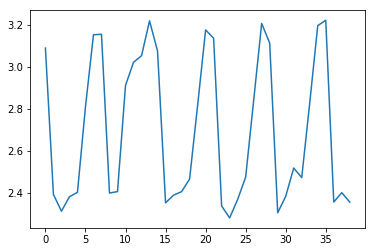

In [31]:
plt.plot(testpreds[129])

In [32]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [33]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.813625   
air_0164b9927d20bcc3_2017-04-23              1.539982   
air_0241aa3964b7f861_2017-04-23              2.355823   
air_0328696196e46f18_2017-04-23              2.094839   
air_034a3d5b40d5b1b1_2017-04-23              3.469017   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.132638  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.664508  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.546805  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.124130  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  31.105162

In [34]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [35]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [36]:
submission.to_csv("../submission/l2_3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')